<a href="https://colab.research.google.com/github/hanbiphyun/ESSA_YB/blob/main/ESAA_YB_week11_%EC%BA%90%EA%B8%80%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###House prices- 주택가격예측
- 앙상블, 스태킹 기법 사용

특성 공학¶
- Inputing missing values
Transforming : 수치형 -> 범주형
- Label Encoding : 범주형 -> 서수형
- Box Cox Transformation : 비대칭 분포 데이터에 대해 좀 더 좋은 결과(리더보드와 cross-validation에서)를 낼 수 있음
- Getting dummy variables : 범주형 특성

알고리즘
- sklearn based model
- DMLS's XGBoost
- Microsoft's LightGBM

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from sklearn.preprocessing import StandardScaler

from scipy import stats

from scipy.stats import norm, skew

import warnings

warnings.filterwarnings('ignore') # warnings 무시

%matplotlib inline


# sns Theme

sns.set_style('darkgrid')

pd.set_option('display.float_format', lambda x : '{:.3f}'.format(x))


In [2]:
train_df= pd.read_csv('/content/house_train.csv')
test_df= pd.read_csv('/content/house_test.csv')

In [3]:
print(train_df.shape, test_df.shape)
train_df.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Id 컬럼 저장
train_id= train_df['Id']
test_id= test_df['Id']

# 예측과정에 불필요한 Id 컬럼 삭제
train_df.drop("Id", axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

Data processing
- outlier 처리

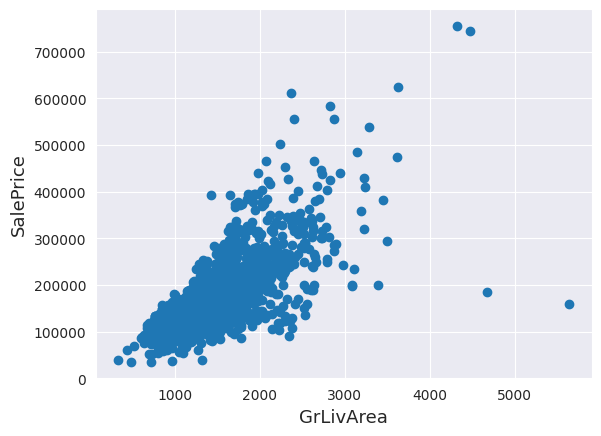

In [5]:
fig, ax= plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

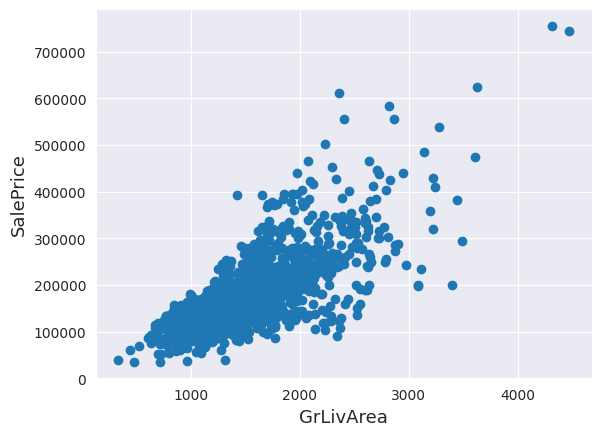

In [6]:
# 이상점 삭제
train_df= train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

# 그래프 재확인
fig, ax= plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

###타겟 변수
- SalePrice
- Q-Q plot : 두 데이터 집단 간의 분포 체크

180932.91906721535 79467.78892987774


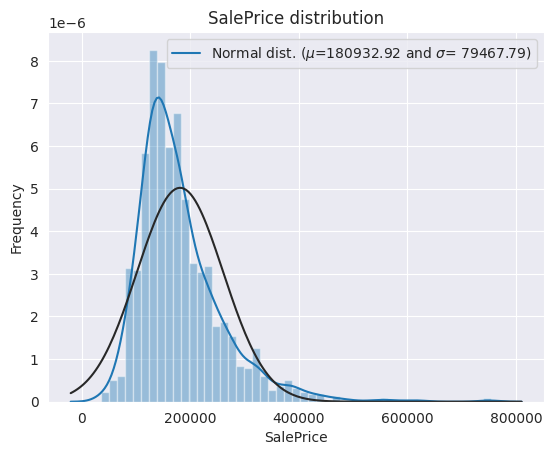

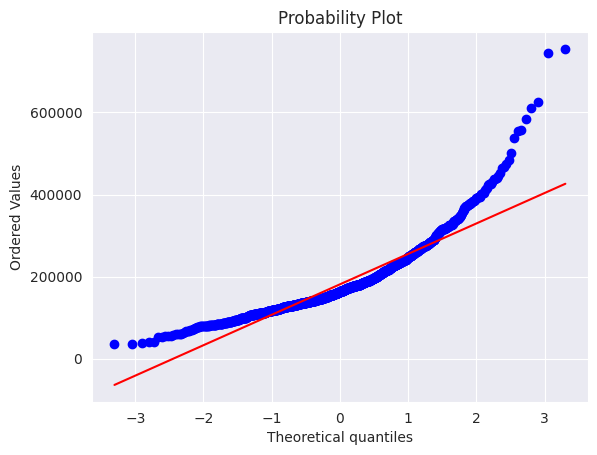

In [7]:
from numpy._core.multiarray import tracemalloc_domain
sns.distplot(train_df['SalePrice'],fit=norm)

# 함수를 이용해 적절한 파라미터 구하기
(mu, sigma)= norm.fit(train_df['SalePrice'])
print(mu, sigma)

# 그래프 그리기
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$= {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Q-Q plot 그리기
fig= plt.figure()
res= stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

- 오른쪽으로 치우쳐진 분포
- numpy의 log1p (log(1+x) 해줌) 함수로 처리

12.024015155682552 0.3995757283645756


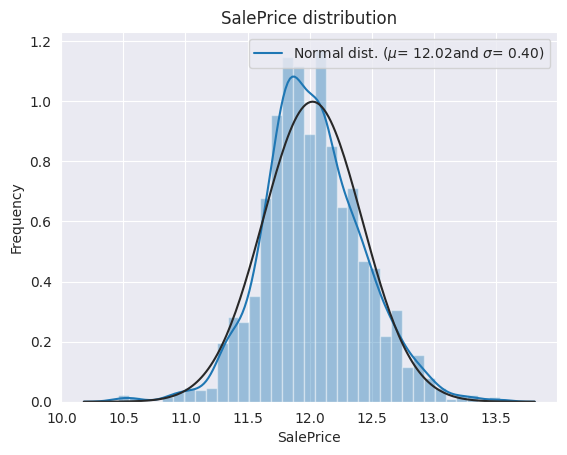

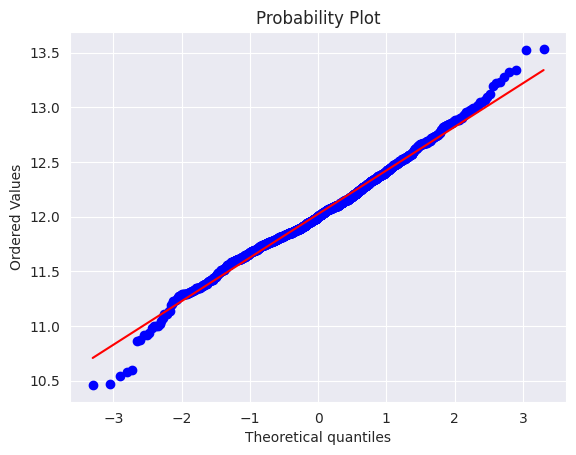

In [8]:
train_df['SalePrice']= np.log1p(train_df['SalePrice'])

sns.distplot(train_df['SalePrice'], fit= norm)
(mu, sigma)= norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$= {:.2f}and $\sigma$= {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig= plt.figure()
res= stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

###피처 엔지니어링

In [9]:
#하나로 묶은 데이터
ntrain= train_df.shape[0]
ntest= test_df.shape[0]

y_train= train_df.SalePrice.values

all_data= pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('all_data size is : {}'.format(all_data.shape))

all_data size is : (2917, 79)


missing data 확인

In [10]:
all_data_na= (all_data.isnull().sum()/ len(all_data))*100
all_data_na= all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending= False)[:30]

missing_data= pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageYrBlt,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

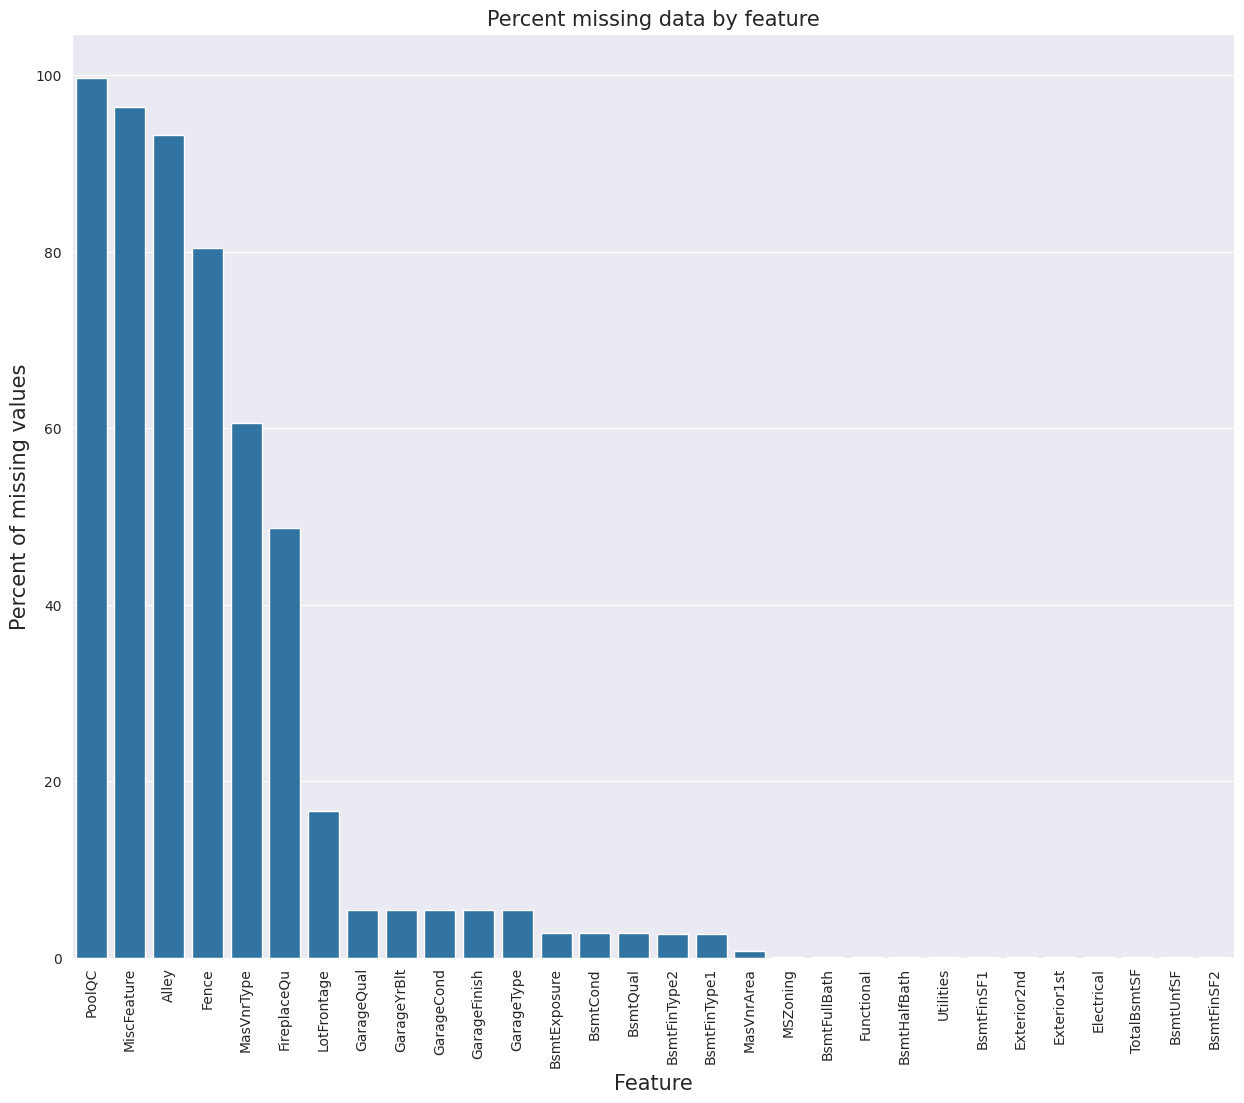

In [11]:
# missing data 시각화
f, ax= plt.subplots(figsize=(15,12))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y= all_data_na)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Data Correlation
- 히트맵으로 상관관계 시각화
- 특히 SalePrice와 다른 요소의 관계 살피기

<Axes: >

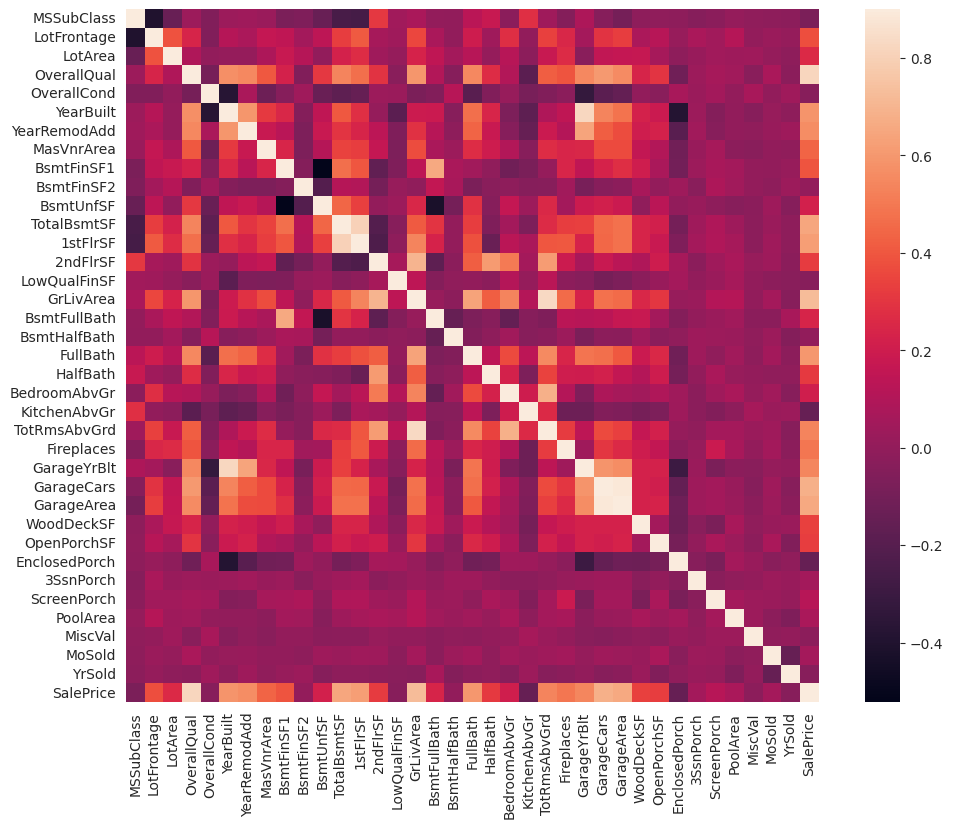

In [12]:
corrmat =train_df.select_dtypes(include=np.number).corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

missing value 채워넣기
- PoolQC : NA 값은 NO Pool 의미 -> 99% 채워주기


In [13]:
all_data['PoolQC']= all_data['PoolQC'].fillna('None')

- MiscFeature : NA는 No misc feature 의미 + Alley, Fence, FireplaceQu 도 함께 처리

In [14]:
all_data['MiscFeature']= all_data['MiscFeature'].fillna('None')
all_data['Alley']= all_data['Alley'].fillna('None')
all_data['Fence']= all_data['Fence'].fillna('None')
all_data['FireplaceQu']= all_data['FireplaceQu'].fillna('None')

- LotFrontage : 거리와 집의 거리 요소, 이웃들의 거리와 유사함 -> 손실값은 이웃들의 중앙값으로 채우기

In [15]:
all_data['LotFrontage']= all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual and GarageCond : None으로 처리

In [16]:
for col in ('GarageType', 'GarageFinish','GarageQual', 'GarageCond'):
    all_data[col]= all_data[col].fillna('None')

In [17]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col]= all_data[col].fillna(0)

In [18]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [19]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- MSZoning (The general zoning classification) : RL이 최빈값으로 빈 부분은 RL로 채움
- mode메서드는 최빈값을 자동으로 선택함

In [21]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- Utilities : 대부분의 값이 'AllPub'이고 예측에 유용하지 않을 것 같으니 drop

In [22]:
all_data= all_data.drop({'Utilities'}, axis=1)

- Functional : NA 는 typical 의미

In [23]:
all_data['Functional']= all_data['Functional'].fillna('Typ')

- Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType : 최빈값으로 채우기

In [24]:
all_data['Electrical']= all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [25]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [26]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [27]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [28]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [29]:
# 안 채워진 값이 있는지 확인
all_data_na= (all_data.isnull().sum()/ len(all_data))*100
all_data_na= all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
missing_data= pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head()

,Missing Ratio


###피처 엔지니어링 이어서
- 수치형 값 중 범주형인 특성 변환

In [30]:
# MSSubClass 는 building class
all_data['MSSubClass']= all_data['MSSubClass'].apply(str)

# OverallCond 변수는 카테고리형 변수로 변환
all_data['OverallCond']= all_data['OverallCond'].apply(str)

# Year, Month sold는 카테고리형 변수로 변환
all_data['YrSold']= all_data['YrSold'].astype(str)
all_data['MoSold']= all_data['MoSold'].astype(str)

- 범주형 데이터를 label encoding으로 변환

In [31]:
from sklearn.preprocessing import LabelEncoder
cols=('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

# LabelEncoder를 카테고리형 변수에 적용
for c in cols:
    lbl= LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c]= lbl.transform(list(all_data[c].values))

print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


주요 피처 추가
- 집의 가용 평수 ->  basement + 1층+ 2층 공간으로 새 특성 만들기 'TotalSF'

In [32]:
all_data['TotalSF']= all_data['TotalBsmtSF']+ all_data['1stFlrSF']+ all_data['2ndFlrSF']

In [33]:
# 피처의 왜곡 정도
numeric_feats = all_data.dtypes[all_data.dtypes!='object'].index

#수치형 데이터에서 왜곡 확인
skewed_feats= all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending= False)

print('\nSkew in numerical features: \n')
skewness= pd.DataFrame({'Skew' : skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


- Box-Cox 변환 : 정규분포가 아닌 데이터를 정규 분포 형태로 변환하는 방법

In [34]:
skewness= skewness[abs(skewness) > 0.75]
print('There are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam= 0.15
for feat in skewed_features:
    all_data[feat]= boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


- get_dummies 를 이용하여 범주형 데이터 변환 -> 다시 train, test_df로 나누기

In [35]:
all_data= pd.get_dummies(all_data)
print(all_data.shape)

train_df= all_data[:ntrain]
test_df= all_data[ntrain:]

(2917, 220)


###모델링

In [36]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


- 교차 검증 전략 -> cross_val_score 사용, K-fold

In [37]:
n_folds=5

def rmsle_cv(model):
    kf= KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse= np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring= 'neg_mean_squared_error', cv= kf))
    return (rmse)

**Base models**
- 라쏘회귀 : 이상치에 민감, pipeline 에 RobustScaler() 메서드 추가해서 이상치 규제
- Elastic Net Regression

In [38]:
lasso= make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet= make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=3))

- Kernel 릿지 회귀

In [39]:
KRR= KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0= 2.5)

- Gradient Boosting 회귀 : huber 손실함수로 이상치 관리 (이상치에 덜 민감한 손실함수)

In [40]:
GBoost= GradientBoostingRegressor(n_estimators= 3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)

- XGBoost : 각 하이퍼 파라미터 설정은 베이지안 최적화 사용

In [41]:
model_xgb= xgb.XGBRegressor(colsample_bytree=0.4603,
                            gamma=0.0468,
                            learning_rate=0.05,
                            max_depth=3,
                            min_child_weight=1.7817,
                            n_estimators=220,
                            reg_alpha=0.4640,
                            reg_lambda= 0.8571,
                            subsample= 0.5213,
                            silent=1,
                            random_state=7,
                            nthread=-1)

- LightGBM

In [42]:
model_lgb= lgb.LGBMRegressor(objective='regression', num_leaves=5,
                            learning_rate=0.05,
                            n_estimators=720,
                            max_bin=55,
                            bagging_fraction=0.8,
                            bagging_freq=5,
                            feature_fraction=0.2319,
                            feature_fraction_seed=9,
                            bagging_seed=9,
                            min_data_in_leaf=6,
                            min_sum_hessian_in_leaf=11)

In [43]:
score= rmsle_cv(lasso)
print('\nLasso score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [44]:
score= rmsle_cv(ENet)
print('ElasticNet score : {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

ElasticNet score : 0.1116 (0.0074)



In [45]:
score= rmsle_cv(KRR)
print('Kernel Ridge score : {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Kernel Ridge score : 0.1153 (0.0075)



In [46]:
score= rmsle_cv(GBoost)
print('Gradient Boosting score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [47]:
score= rmsle_cv(model_xgb)
print('Xgboost score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Xgboost score: 0.1201 (0.0074)



In [48]:
score= rmsle_cv(model_lgb)
print('LGBM score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

**Stacking models**
- 가장 쉬운 접근 : base models 평균구하기

In [49]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models=models

    def fit(self, X, y):
        self.models_= [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self

    #모델 예측과 평균 구하기
    def predict(self, X):
        predictions= np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [50]:
# 모델들의 평균 점수
averaged_models= AveragingModels(models=(ENet, GBoost, KRR, lasso))

score= rmsle_cv(averaged_models)
print('Averaged base models score: {:.4f} ({:.4f})\n'.format(score.mean(), score.std()))

Averaged base models score: 0.1087 (0.0077)



메타 모델을 추가하는 방법 - base model의 평균과 out-of-folds 예측을 이용해 메타 모델을 훈련시킨다.
1. 훈련데이터를 train, holdout 으로 나눔
2. train 데이터로 훈련함
3. holdout 데이터로 테스트함
4. 3을 통해 예측값구하고 메타모델로 그 예측값을 이용해 모델학습함
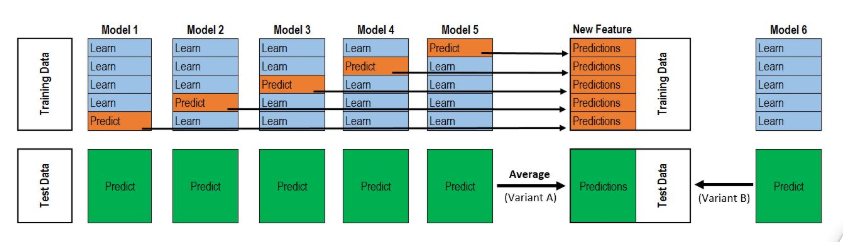

Stacking averaged models class
- 베이스 모델의 예측값을 하나의 특성으로 사용해 최종 분류 만드는 것임

In [51]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models= base_models
        self.meta_model= meta_model
        self.n_folds= n_folds

    # base model은 2차원 배열
    def fit(self, X, y):
        self.base_models_=[list() for x in self.base_models]
        self.meta_model_= clone(self.meta_model)
        kfold= KFold(n_splits= self.n_folds, shuffle=True, random_state=156)

        # cloned base models를 훈련시키고 out-of-fold 예측 생성
        # cloned meta model 훈련필요함
        out_of_fold_predictions= np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X,y):

                instance= clone(model)

                self.base_models_[i].append(instance)

                instance.fit(X[train_index], y[train_index])

                y_pred= instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i]= y_pred

        # out-of-fold 예측을 이용해 메타모델 학습
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # 각 모델의 평균값 사용
    def predict(self, X):
        meta_features= np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)

            for base_models in self.base_models_])

        return self.meta_model_.predict(meta_features)

성능비교

In [52]:
stacked_averaged_models= StackingAveragedModels(
    base_models=(ENet, GBoost, KRR),
    meta_model=(lasso)
)

score= rmsle_cv(stacked_averaged_models)
print('Stacking Averaged models score : {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Stacking Averaged models score : 0.1081 (0.0073)


###Emsembling StackedRegressor, XGBooost, LightGBM
- 최종결과 완성

In [53]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

마지막 훈련과 예측

In [54]:
# StackedRegressor
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred= stacked_averaged_models.predict(train_df.values)
stacked_pred= np.expm1(stacked_averaged_models.predict(test_df.values))

print(rmsle(y_train, stacked_train_pred))

0.078395060966657


In [55]:
#XGBoost
model_xgb.fit(train_df, y_train)
xgb_train_pred= model_xgb.predict(train_df)
xgb_pred= np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

0.09371842395250982


In [56]:
#LightGBM
model_lgb.fit(train_df, y_train)
lgb_train_pred= model_lgb.predict(train_df)
lgb_pred= np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23

In [57]:
# RMSE of 전체 훈련데이터 평균 구할때
print('RMSLE score on train data:')
print(rmsle(y_train, stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15))

RMSLE score on train data:
0.07732741445257807


Ensemble 예측
- CV 결과 StackedRegressor 값이 낮았기 때문에 앙상블 시 가중치를 더 크게 부여함

In [58]:
ensemble= stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [59]:
sub= pd.DataFrame()
sub['Id']= test_id
sub['SalePrice']= ensemble
sub.to_csv('submission.csv', index=False)